In [4]:
# Imports
import pandas as pd
import numpy as np
from datetime import date, timedelta
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import geopy.distance
import statistics as stats
import os
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import LineString, Point
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import os
import zipfile
import pandas as pd
import json
import numpy as np
import pandas as pd
import pycaret
import os
import fiona
import pprint
import IPython
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pyreadr
import shapely
import warnings
import geopandas as gpd
import osmnx as ox
from shapely.geometry import box
import numpy as np
import contextily as ctx

In [17]:
# Load the CSV file into a DataFrame with a different encoding

tunja_1 = pd.read_csv(r'C:\Users\genin\Box Sync\MY DOCUMENTS\Proyecto Casas e Inmuebles\data capturas\tunja_2023-09-08.csv')
tunja_2 = pd.read_csv(r'C:\Users\genin\Box Sync\MY DOCUMENTS\Proyecto Casas e Inmuebles\data capturas\tunja_2024-01-14.csv')
tunja_3 = pd.read_csv(r'C:\Users\genin\Box Sync\MY DOCUMENTS\Proyecto Casas e Inmuebles\data capturas\tunja_2023-10-03.csv')
tunja_4 = pd.read_csv(r'C:\Users\genin\Box Sync\MY DOCUMENTS\Proyecto Casas e Inmuebles\data capturas\tunja_2023-11-22.csv')
tunja_5 = pd.read_csv(r'C:\Users\genin\Box Sync\MY DOCUMENTS\Proyecto Casas e Inmuebles\data capturas\tunja_2024-09-22.csv')

data_set = pd.concat([tunja_1, tunja_2, tunja_3, tunja_4, tunja_5], axis=0, join='outer', ignore_index=True)
data_set = data_set[data_set['tipo']=='apartamento']

no_include = ['Name','ID','Barrio','tipo','Parking/admin_value']
data_set = data_set.drop(columns=no_include)

### Clean Precio ##

data_set['Precio'] = data_set['Precio'].str.replace('$', '', regex=False)
data_set['Precio'] = data_set['Precio'].str.replace('.', '', regex=False)
data_set['Precio'] = pd.to_numeric(data_set['Precio'], errors='coerce')/1000000

### Area ###

data_set['Area Construida'] = data_set['Area Construida'].str.replace('m²', '', regex=False)
data_set['Area Construida'] = pd.to_numeric(data_set['Area Construida'], errors='coerce')

data_set['Area Total'] = data_set['Area Total'].str.replace('m²', '', regex=False)
data_set['Area Total'] = pd.to_numeric(data_set['Area Total'], errors='coerce')

### Longitud and Lat ###

data_set['lat'] = pd.to_numeric(data_set['lat'], errors='coerce')
data_set['lon'] = pd.to_numeric(data_set['lon'], errors='coerce')


## Load Tunja Map

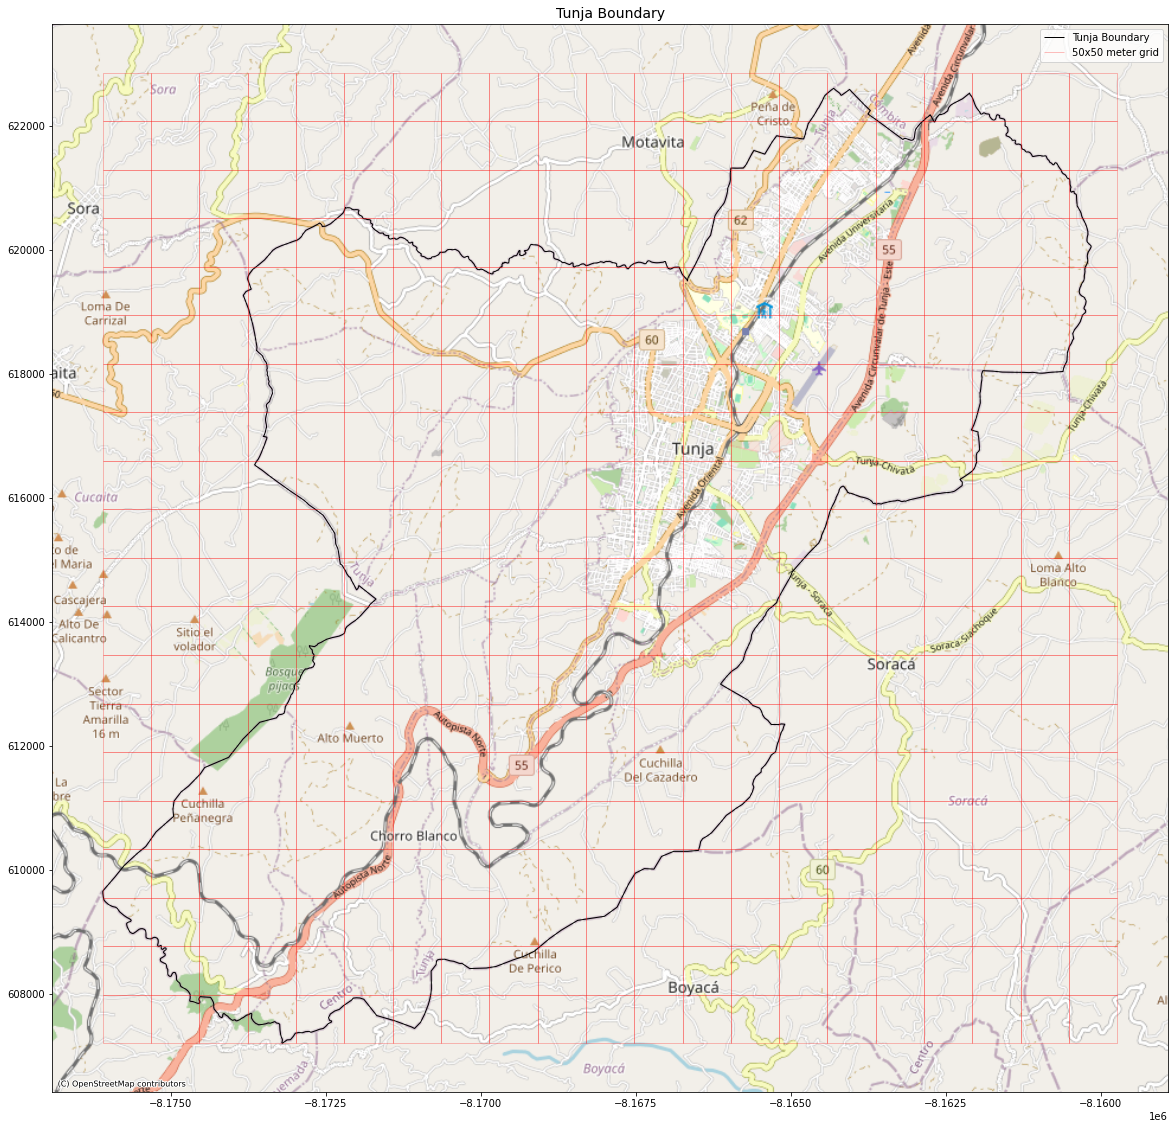

In [19]:
# 1. Download Buenos Aires map data using osmnx
city = ox.geocode_to_gdf('Tunja, Colombia')

# 2. Define a function to create a grid of 50x50 meters
def create_grid(city_gdf, cell_size=0.007):
    bounds = city_gdf.total_bounds  # Get city bounding box [minx, miny, maxx, maxy]
    xmin, ymin, xmax, ymax = bounds
    cols = np.arange(xmin, xmax + cell_size, cell_size)
    rows = np.arange(ymin, ymax + cell_size, cell_size)
    
    # Generate grid cells
    grid_cells = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            grid_cells.append(box(x, y, x + cell_size, y + cell_size))
    
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=city_gdf.crs)
    return grid

# 3. Create the grid
grid_50m = create_grid(city)

# 4. Plot Buenos Aires map with the 50x50 meter grid and OSM basemap
fig, ax = plt.subplots(figsize=(20, 20))

city = city.to_crs(epsg=3857)

# Plot the city boundary
city.to_crs(epsg=3857).boundary.plot(ax=ax, color='black', linewidth=1, label='Tunja Boundary')

# Plot the grid
grid_50m.to_crs(epsg=3857).boundary.plot(ax=ax, color='red', linewidth=0.5, alpha=0.5, label='50x50 meter grid')

# Add OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title and legend
ax.set_title('Tunja Boundary', fontsize=14)
ax.legend()

# Show the plot
plt.show()


In [74]:
geometry = [Point(xy) for xy in zip(data_set['lon'], data_set['lat'])]
geo_houses = gpd.GeoDataFrame(data_set, geometry=geometry, crs='EPSG:4326')


city = ox.geocode_to_gdf('Tunja, Colombia')
city = city.to_crs(epsg=4326)

# 2. Define a function to create a grid of 50x50 meters
def create_grid(city_gdf, cell_size=0.007):
    bounds = city_gdf.total_bounds  # Get city bounding box [minx, miny, maxx, maxy]
    xmin, ymin, xmax, ymax = bounds
    cols = np.arange(xmin, xmax + cell_size, cell_size)
    rows = np.arange(ymin, ymax + cell_size, cell_size)
    
    # Generate grid cells
    grid_cells = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            grid_cells.append(box(x, y, x + cell_size, y + cell_size))
    
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=city_gdf.crs)
    return grid

# 3. Create the grid
geo_houses = geo_houses.to_crs(epsg=3857)
city = city.to_crs(epsg=3857)
grid_50m = grid_50m.to_crs(epsg=3857)

classified_points = gpd.sjoin(geo_houses, grid_50m, how='left', op='within')
classified_points = classified_points.rename(columns={'index_right': 'grid_id'})

# Convert the geometry column to WKT format
classified_points['geometry'] = classified_points['geometry'].apply(lambda geom: geom.wkt)
classified_points = classified_points.dropna(subset=['grid_id'])
classified_points['grid_id'] = classified_points['grid_id'].astype(str)

In [75]:
no_include = ['lat','lon','geometry', 'Other Variable', 'list', 'Descripcion']
classified_points = classified_points.drop(columns=no_include)
classified_points = classified_points[classified_points['Precio']<700]

In [76]:
import pycaret
from pycaret.regression import *

s = setup(data = classified_points , target = 'Precio', session_id=123)

,Description,Value
0,Session id,123
1,Target,Precio
2,Target type,Regression
3,Original data shape,"(677, 194)"
4,Transformed data shape,"(677, 210)"
5,Transformed train set shape,"(473, 210)"
6,Transformed test set shape,"(204, 210)"
7,Numeric features,188
8,Categorical features,5
9,Rows with missing values,100.0%


In [77]:
best = compare_models(n_select=10)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:10:22
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,35.6564,3978.5580,60.7414,0.8086,0.2641,0.7813,3.1240
lightgbm,Light Gradient Boosting Machine,35.7345,3989.8682,60.7500,0.8085,0.2519,0.8445,0.1780
rf,Random Forest Regressor,35.1914,4133.6713,62.2196,0.8014,0.2589,0.8101,0.4390
gbr,Gradient Boosting Regressor,41.3102,4265.6454,63.2512,0.7967,0.2659,0.8456,0.2250
et,Extra Trees Regressor,33.5360,4275.1796,63.3519,0.7926,0.2609,0.7415,0.5090
xgboost,Extreme Gradient Boosting,34.0513,4486.7603,64.1540,0.7876,0.2814,0.8057,0.2910
knn,K Neighbors Regressor,49.1303,6366.0825,77.0388,0.6886,0.3132,0.6241,0.0910
dt,Decision Tree Regressor,41.6774,6822.6884,81.6981,0.6685,0.3610,0.8527,0.0850
ada,AdaBoost Regressor,63.5844,7323.6012,84.7981,0.6472,0.3595,0.9290,0.1920
dummy,Dummy Regressor,122.3392,21128.6106,144.9780,-0.0181,0.5334,0.9510,0.0730


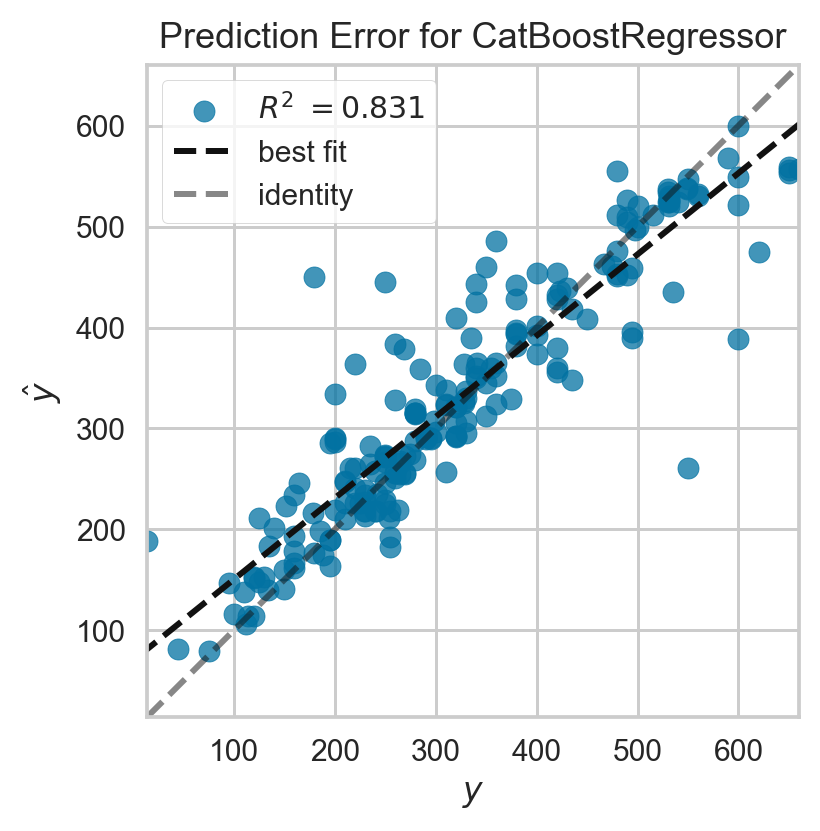

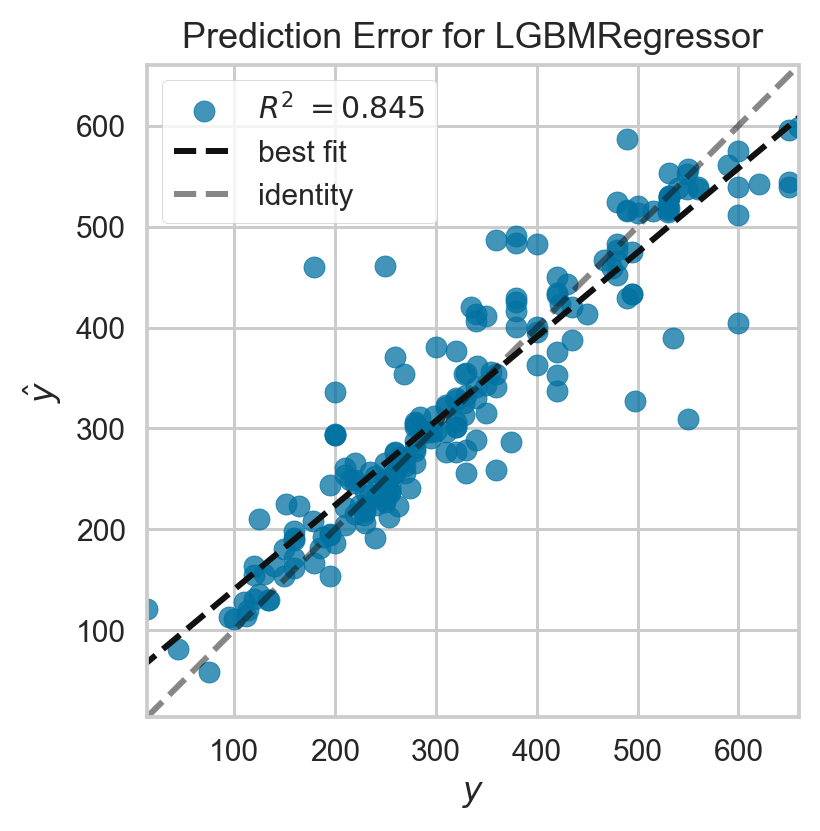

In [78]:
plot_model(best[0], plot = 'error', scale=3);
plot_model(best[1], plot = 'error', scale=3)

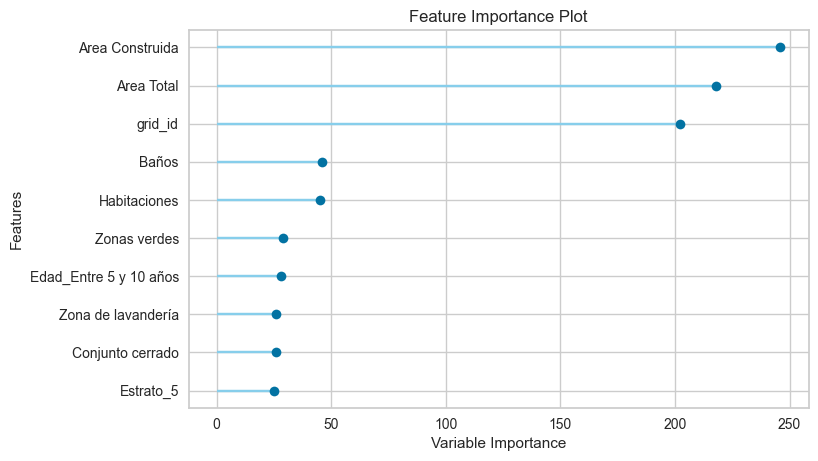

In [79]:
# plot feature importance
plot_model(best[1], plot = 'feature')

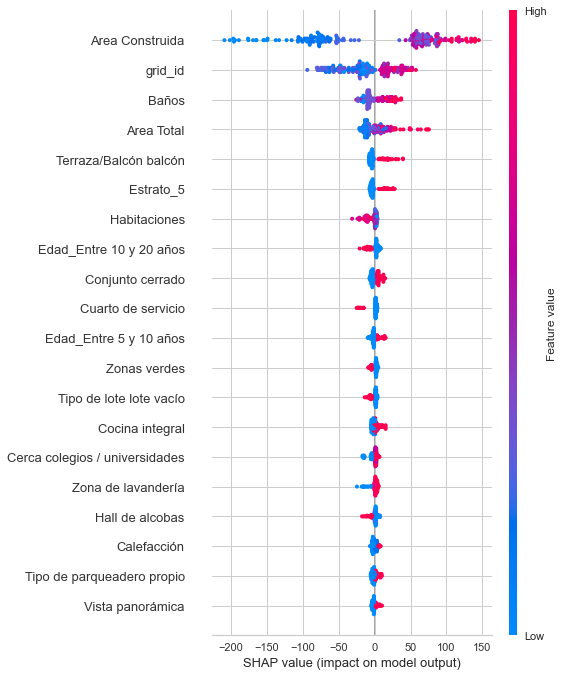

In [80]:
interpret_model(best[1], plot = 'summary')

In [81]:
prediction = predict_model(best[1], data=classified_points)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,20.7222,1411.4627,37.5694,0.9317,0.2382,0.3403


In [82]:
prediction

,Edad,Area Construida,Area Total,Estrato,Habitaciones,Baños,Patio,Deposito 1,Piso 2,Tipo de comedor sala comedor,...,Tipo de calentador gas,Número de niveles 3,Zona Comercial,Baño de Servicio,Tipo comedor comedor independiente,Shut de basura,Ancho 1 m,grid_id,Precio,prediction_label
3,Entre 0 y 5 años,28.600000,28.600000,3.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211.0,111.540001,112.802065
4,Entre 5 y 10 años,137.000000,137.000000,5.0,4.0,4.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.0,531.000000,528.648186
8,Entre 10 y 20 años,354.000000,354.000000,3.0,2.0,2.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228.0,530.427124,510.887712
12,Entre 5 y 10 años,137.539993,137.539993,5.0,5.0,5.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273.0,531.000000,527.735761
14,Entre 0 y 5 años,112.000000,112.000000,3.0,3.0,2.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.0,290.000000,289.605019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,Entre 5 y 10 años,103.000000,103.000000,5,3.0,2.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272.0,260.000000,370.353811
1387,Más de 20 años,150.000000,150.000000,3,4.0,3.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,318.0,335.000000,336.436177
1388,Entre 10 y 20 años,89.500000,89.500000,4,3.0,3.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,272.0,280.000000,301.446022
1398,Más de 20 años,62.000000,63.000000,3,3.0,1.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,234.0,168.000000,175.179860


In [85]:
prediction['date']

3        9/8/2023
4        9/8/2023
8        9/8/2023
12       9/8/2023
14       9/8/2023
          ...    
1382    9/22/2024
1387    9/22/2024
1388    9/22/2024
1398    9/22/2024
1400    9/22/2024
Name: date, Length: 677, dtype: category
Categories (5, object): ['1/14/2024', '10/3/2023', '11/22/2023', '9/22/2024', '9/8/2023']

In [92]:
prediction['flag']= np.where(prediction['Precio']<prediction['prediction_label'],1,0)
flag_ap = prediction[(prediction['date'] == '9/22/2024')]


In [93]:
os.chdir('C:\\Users\\genin\\Box Sync\\MY DOCUMENTS\\Proyecto Casas e Inmuebles\\data capturas\\')
flag_ap.to_csv('possible.csv',index=False)